In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterVector

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import optimizer to optimize the variational cirucit
from qiskit.aqua.components.optimizers import COBYLA

from qiskit import Aer

from qiskit.providers.aer import StatevectorSimulator


In [3]:
provider = IBMQ.load_account()

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()


## Make the compressed XYZ gate a variational gate

In [5]:
# This is the compressed variational XYZ gate
def R_xyz_variational(theta, trotter_step, i):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*theta[3*(trotter_step+i)+3*trotter_step]-np.pi/2, 0)
    t_qc.rz(2 * theta[3*(trotter_step+i) + 1 + 3*trotter_step], 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * theta[3*(trotter_step+i) + 2 + 3*trotter_step], 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [6]:
theta = ParameterVector('theta', 3*2*4)

In [7]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

### Alternative 1

# Get the simple stuff to work first!

for trotter_step in range(0, 4):
    for i in range(0, num_qubits - 1):
        Trot_qc.append(R_xyz_variational(theta, trotter_step, i).to_instruction(), [Trot_qr[i], Trot_qr[i+1]])

### Alternative 2

# Trot_qc.append(R_xyz(2*t).to_instruction(), [Trot_qr[0], Trot_qr[1]])
# Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[1], Trot_qr[2]])
# Trot_qc.append(R_xyz(3*t).to_instruction(), [Trot_qr[0], Trot_qr[1]])
# Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[1], Trot_qr[2]])
# Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[0], Trot_qr[1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

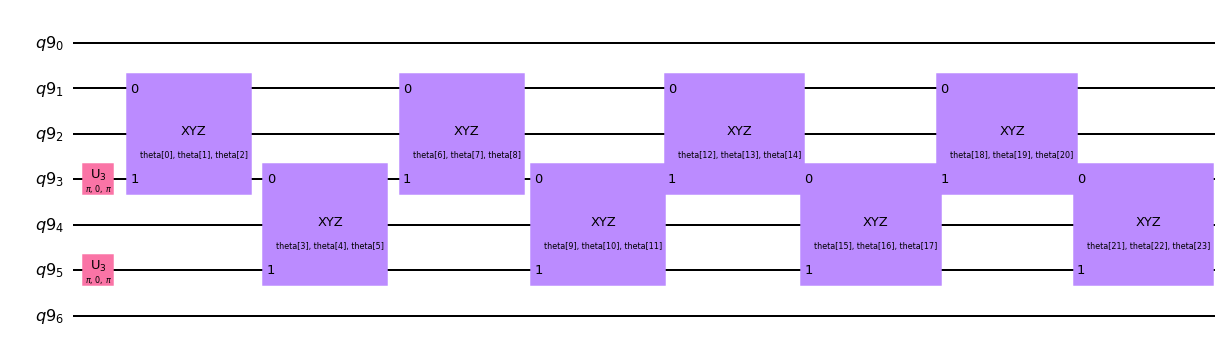

In [8]:
# The final time of the state evolution
# target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
## Standard and alternative 1

#for _ in range(trotter_steps):
#    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
## Alternative 2
qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#qc = qc.bind_parameters({t: target_time/trotter_steps})

qc.decompose().draw(output="mpl")  # view decomposition of trotter gates

In [9]:
def get_var_form(theta):
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    for trotter_step in range(0, 4):
        for i in range(0, num_qubits - 1):
            Trot_qc.append(R_xyz_variational(theta, trotter_step, i).to_instruction(), [Trot_qr[i], Trot_qr[i+1]])
    
    Trot_gate = Trot_qc.to_instruction()
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    # qc.measure(qr, [qr[1], qr[3], qr[5]])
    return qc, qr

In [10]:
def objective_function(params):

    # TODO: Put Stefano's algorithm here

    backend = Aer.get_backend('statevector_simulator')

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.x([3,5])
    result = execute(qc, backend).result()
    target_state = result.get_statevector(qc) 

    qc, _ = get_var_form(theta)
    qc = qc.bind_parameters({theta: params})

    result = execute(qc, backend).result()
    state = result.get_statevector(qc)
    cost = 1 - state_fidelity(target_state, state)
    
    return cost

In [11]:
# Optimize the circuit parameters
optimizer = COBYLA(maxiter=500, tol=0.0001)
params = np.random.rand(3*4*2)
ret = optimizer.optimize(num_vars=3*4*2, objective_function=objective_function, initial_point=params)

In [12]:
objective_function(ret[0])

8.675458129658864e-09

In [13]:
# Check fidelity using full state tomography
qc, qr = get_var_form(theta)
qc = qc.bind_parameters({theta: ret[0]})
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

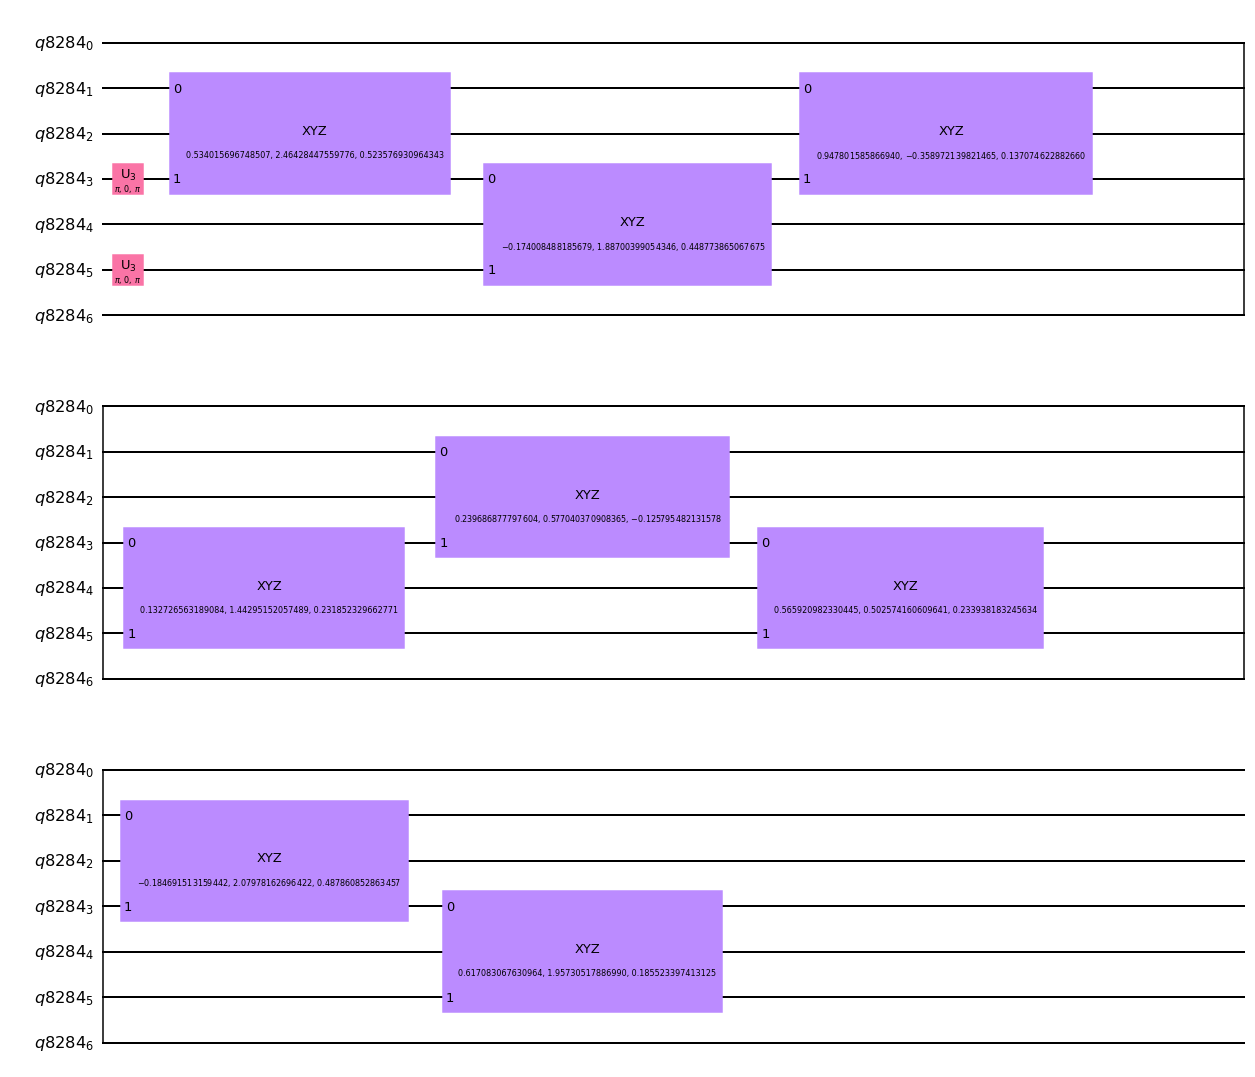

In [14]:
qc.decompose().draw(output="mpl") 

In [17]:
shots = 8192
reps = 1
# backend = sim_noisy_jakarta
backend = Aer.get_backend('aer_simulator_statevector')
# reps = 8
#backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 3131bf7d-bc9f-4ad4-8aa1-4ebcd698cc11


In [19]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.9964 ± 0.0000
